In [5]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### Carregando o dataset rock_paper_scissors

In [2]:
(ds_train, ds_test), info = tfds.load('rock_paper_scissors',
                        split=['train', 'test'],
                        shuffle_files=True,
                        with_info=True)

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)



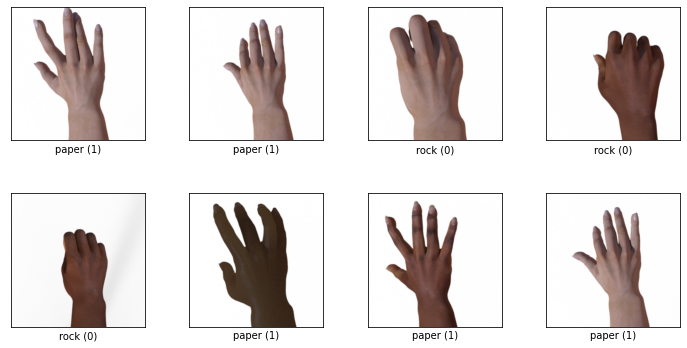

In [6]:
tfds.show_examples(ds_train, info, rows=2, cols=4)
plt.close()